# Employee Attrition Prediction
There is a class of problems that predict that some event happens after N years. Examples are employee attrition, hard drive failure, life expectancy, etc. 

Usually these kind of problems are considered simple problems and are the models have vairous degree of performance. Usually it is treated as a classification problem, predicting if after exactly N years the event happens. The problem with this approach is that people care not so much about the likelihood that the event happens exactly after N years, but the probability that the event happens today. While you can infer this using Bayes theorem, doing it during prediction will not give you good accuracy because the Bayesian inference will be based on one piece of data. It is better to do this kind of inference during training time, and learn the probability than the likelihood function.

Thus, the problem is learning a conditional probability of the person quitting, given he has not quit yet, and is similar to the Hazard function in survival analysis problem

In [2]:
#Import
import numpy as np
import pandas as pd
import numpy.random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import math
%matplotlib inline
numpy.random.seed(1239)

C:\Users\michael\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Read the data
# Source: https://www.ibm.com/communities/analytics/watson-analytics-blog/hr-employee-attrition/
raw_data = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [3]:
#Check if any is nan. If no nans, we don't need to worry about dealing with them
raw_data.isna().sum().sum()

0

In [4]:
def prepare_data(raw_data):
    '''
    Prepare the data
    1. Set EmployeeNumber as the index
    2. Drop redundant columns
    3. Reorder columns to make YearsAtCompany first
    4. Change OverTime to the boolean type
    5. Do 1-hot encoding
    '''
    labels = raw_data.Attrition == 'Yes'
    employee_data = raw_data.set_index('EmployeeNumber').drop(columns=['Attrition', 'EmployeeCount', 'Over18'])
    employee_data.loc[:, 'OverTime'] = (employee_data.OverTime == 'Yes').astype('float')
    employee_data = pd.get_dummies(employee_data)
    employee_data = pd.concat([employee_data.YearsAtCompany, employee_data.drop(columns='YearsAtCompany')], axis=1)
    return employee_data, labels


In [5]:
#Split to features and labels
employee_data, labels = prepare_data(raw_data)

,YearsAtCompany,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,6,41,1102,1,2,2,94,3,2,4,...,0,0,0,0,0,1,0,0,0,1
2,10,49,279,8,1,3,61,2,2,2,...,0,0,0,0,1,0,0,0,1,0
4,0,37,1373,2,2,4,92,2,1,3,...,1,0,0,0,0,0,0,0,0,1
5,8,33,1392,3,4,4,56,3,1,3,...,0,0,0,0,1,0,0,0,1,0
7,2,27,591,2,1,1,40,3,1,2,...,1,0,0,0,0,0,0,0,1,0
8,7,32,1005,2,2,4,79,3,1,4,...,1,0,0,0,0,0,0,0,0,1
10,1,59,1324,3,3,3,81,4,1,1,...,1,0,0,0,0,0,0,0,1,0
11,1,30,1358,24,1,4,67,3,1,3,...,1,0,0,0,0,0,0,1,0,0
12,9,38,216,23,3,4,44,2,3,3,...,0,0,1,0,0,0,0,0,0,1


First we will work on the synthetic set of data, for this reason we will not split the dataset to train/test yet

In [8]:
#Now scale the entire dataset, but not the first column (YearsAtCompany). Instead scale the dataset to be similar range
#to the first column
max_year = employee_data.YearsAtCompany.max()
scaler = MinMaxScaler(feature_range=(0, max_year))
scaled_data = pd.DataFrame(scaler.fit_transform(employee_data.values.astype('float')),
                           columns=employee_data.columns,
                          index=employee_data.index)


Based on the chart it seems like a realistic data set.
Now we need to construct our loss function. It will have an additional parameter: number of years

We define probability $p(x, t)$ that the person quits this very day, where t is the number of years and x is the remaining features. Then the likelihood that the person has quit after the year $t$  is 
$$P(x,t) = (\prod_{l=0}^{t-1} (1-p(x,l))) p(x,t) $$ whereas the likelihood that the person will remain after the year $t$ is 
$$P(x,t) = \prod_{l=0}^{t} (1-p(x,l)) $$
Strictly speaking x is also dependent on t, but we don't have the historical data for this, so we assume that x is independent of t.

Using the principle of maximum likelihood, we derive the loss function taking negative log of the likelihood function:
$$\mathscr{L}(y,p) = -\sum_{l=0}^{t-1} \log(1-p(x,l)) - y \log{p} - (1-y) \log(1-p) $$
Where y is an indicator if the person has quit after working exactly t years or not.
Notice that the last two terms is the cross-entropy loss function, and the first term is a hitorical term. 

We will use a modified Cox Hazard function mechanism and model the conditional probability $p(x,l)$  a sigmoid function (for simplicity we include bias in the list of weights, and so the weight for the t parameter): $$p=\frac{1}{1 + e^{-\bf{w}\bf{x}}}$$





To create a synthetic set we assume that p does not depend on anything. Then the maximum likelihood gives us this simple formula: $$Pos=M p \bar{t}$$ 
Here Pos is the number of positive example (people who quit) and M is the total number of examples and $\bar{t}$ is the mean time (number of years)


In [10]:
#pick a p
p = 0.01
#Get the maximum years. We need it to make sure that the product of p YearsAtCompany never exceeds 1.
#In reality that is not a problem, but we will use it to correctly create synthetic labels
scaled_data.YearsAtCompany.max()

40.0

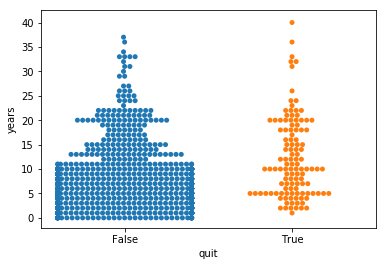

In [11]:
#Create  the synthetic labels. 
synthetic_labels = numpy.random.rand(employee_data.shape[0]) < p * employee_data.YearsAtCompany
#Plot the data with the synthetic labels
sns.swarmplot(y='years', x='quit', data=pd.DataFrame({"quit":synthetic_labels, 'years':employee_data.YearsAtCompany}));

In [12]:
#We expect the probability based on the synthesized data (but we are getting something else....) to be close to p
synthetic_labels.sum()/len(synthetic_labels)/employee_data.YearsAtCompany.mean()

0.0114540865851291

Indeed pretty close to the value of p we set beforehand

## Logistic Regression with the synthetic labels

In this version of the POC we will use TensorFlow

We need to add ones to the dataframe.
But since we scaled everything to be between `0` and `40`, the convergence will be faster if we add `40.0` instead of `1`

In [86]:
#Add 1 to the employee data.
#But to make convergence fa
scaled_data['Ones'] = 40.0

In [78]:
scaled_data

,YearsAtCompany,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Ones
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,6.0,21.904762,28.632785,0.000000,10.0,13.333333,36.571429,26.666667,10.0,40.000000,...,0.0,0.0,0.0,0.0,40.0,0.0,0.0,0.0,40.0,1.0
2,10.0,29.523810,5.068003,10.000000,0.0,26.666667,17.714286,13.333333,10.0,13.333333,...,0.0,0.0,0.0,40.0,0.0,0.0,0.0,40.0,0.0,1.0
4,0.0,18.095238,36.392269,1.428571,10.0,40.000000,35.428571,13.333333,0.0,26.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1.0
5,8.0,14.285714,36.936292,2.857143,30.0,40.000000,14.857143,26.666667,0.0,26.666667,...,0.0,0.0,0.0,40.0,0.0,0.0,0.0,40.0,0.0,1.0
7,2.0,8.571429,14.001432,1.428571,0.0,0.000000,5.714286,26.666667,0.0,13.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,1.0
8,7.0,13.333333,25.855404,1.428571,10.0,40.000000,28.000000,26.666667,0.0,40.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1.0
10,1.0,39.047619,34.989263,2.857143,20.0,26.666667,29.142857,40.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,1.0
11,1.0,11.428571,35.962777,32.857143,0.0,40.000000,21.142857,26.666667,0.0,26.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,0.0,1.0
12,9.0,19.047619,3.264137,31.428571,20.0,40.000000,8.000000,13.333333,20.0,26.666667,...,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1.0


In [14]:
def reset_graph(seed=1239):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [22]:
def create_year_column(X, w, year):
    year_term = tf.reshape(X[:,0]-year, (-1,1)) * w[0]
    year_column = tf.reshape(X @ w - year_term,(-1,))
    return year_column * tf.cast(tf.greater(X[:,0],year), dtype=tf.float32)

In [52]:
def logit(X, w):
    '''
    
    IMPORTANT: This assumes that the weight for the temporal variable is w[0]
    TODO: Remove this assumption and allow to specify the index of the temporal variable
    '''
    max_year_tf = tf.reduce_max(X[:,0])
    tensors = tf.map_fn(lambda year: create_year_column(X, w, year), tf.range(max_year_tf))
    return tf.transpose(tensors)

In [55]:
logit_result = logit(X,weights)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    result = logit_result.eval()
result[1]

array([0.58763313, 0.5893233 , 0.59101343, 0.5927036 , 0.5943938 ,
       0.59608394, 0.5977741 , 0.59946424, 0.60115445, 0.6028446 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [62]:
def get_loss(X, y, w):
    '''
    The loss function
    '''
    #The first term
    logit_ = logit(X, w)
    temp_tensor = tf.sigmoid(logit_) * tf.cast(tf.greater(logit_, 0), tf.float32)
    sum_loss = tf.reduce_sum(tf.log(1-temp_tensor),1)
    sum_loss = tf.reshape(sum_loss, (-1,1))
    logistic_prob = tf.sigmoid(X @ w)
    return -sum_loss - y * tf.log(logistic_prob) - (1-y) * tf.log(1-logistic_prob)


In [65]:
loss_result = get_loss(X, y, weights/100)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    result = loss_result.eval()
result

array([[4.865529  ],
       [7.657453  ],
       [0.69124424],
       ...,
       [0.69287854],
       [7.0326567 ],
       [3.4933963 ]], dtype=float32)

In [101]:
reset_graph()

learning_rate = 0.0005
l2 = 2.0


X = tf.constant(scaled_data.values, dtype=tf.float32, name="X")
y = tf.constant(synthetic_labels.values.reshape(-1, 1), dtype=tf.float32, name="y")
weights = tf.Variable(tf.random_uniform([scaled_data.values.shape[1], 1], -0.01, 0.01, seed=1239), name="weights")
loss =  get_loss(X, y, weights)

l2_regularizer = tf.nn.l2_loss(weights) - 0.5 * weights[-1] ** 2

cost =  tf.reduce_mean(loss) + l2 * l2_regularizer

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
training_op = optimizer.minimize(cost)
        

In [102]:
init = tf.global_variables_initializer()
n_epochs = 20000


with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 1000 == 0:
            print("Epoch", epoch, "Cost =", cost.eval())
            print(f'w: {weights[-1].eval()}')
        sess.run(training_op)
    
    best_theta = weights.eval()

Epoch 0 Cost = [0.4480857]
w: [-0.00260041]
Epoch 1000 Cost = [0.25044656]
w: [-0.04913734]
Epoch 2000 Cost = [0.24958777]
w: [-0.06650413]
Epoch 3000 Cost = [0.24919516]
w: [-0.07856989]
Epoch 4000 Cost = [0.2489799]
w: [-0.08747929]
Epoch 5000 Cost = [0.24980566]
w: [-0.09409016]
Epoch 6000 Cost = [0.24926803]
w: [-0.09901612]
Epoch 7000 Cost = [0.24923217]
w: [-0.10267571]
Epoch 8000 Cost = [0.24968402]
w: [-0.10539492]
Epoch 9000 Cost = [0.24967311]
w: [-0.10741644]
Epoch 10000 Cost = [0.2496681]
w: [-0.10891172]
Epoch 11000 Cost = [0.24966364]
w: [-0.1100379]
Epoch 12000 Cost = [0.24966182]
w: [-0.11086603]
Epoch 13000 Cost = [0.24966045]
w: [-0.11149137]
Epoch 14000 Cost = [0.24966016]
w: [-0.11194912]
Epoch 15000 Cost = [0.24965991]
w: [-0.11229044]
Epoch 16000 Cost = [0.24965975]
w: [-0.1125449]
Epoch 17000 Cost = [0.24965967]
w: [-0.11273381]
Epoch 18000 Cost = [0.24966054]
w: [-0.1128688]
Epoch 19000 Cost = [0.2496596]
w: [-0.11298056]


The cost will never go down to zero, because of the additional term in the loss function.

In [113]:
#We will print the learned weights.
learned_weights = [(column_name,float(best_theta[column_num])) \
                    for column_num, column_name in enumerate(scaled_data.columns)]

In [117]:
#We print the weights sorted by the absolute value of the value
sorted(learned_weights, key=lambda x: abs(x[1]), reverse=True)

[('Ones', -0.11305734515190125),
 ('YearsAtCompany', 0.0328664667904377),
 ('YearsInCurrentRole', 0.026697276160120964),
 ('TrainingTimesLastYear', 0.018857110291719437),
 ('YearsWithCurrManager', 0.017670977860689163),
 ('TotalWorkingYears', 0.017656395211815834),
 ('JobRole_Human Resources', -0.013450033031404018),
 ('Department_Sales', -0.012433602474629879),
 ('Department_Human Resources', 0.010969753377139568),
 ('StockOptionLevel', 0.010752729140222073),
 ('JobLevel', 0.010262694209814072),
 ('EducationField_Human Resources', 0.00936972163617611),
 ('Education', -0.00919969379901886),
 ('MonthlyRate', 0.008436294272542),
 ('EducationField_Technical Degree', -0.008018920198082924),
 ('EducationField_Marketing', 0.007276634685695171),
 ('JobRole_Healthcare Representative', 0.007259353529661894),
 ('EnvironmentSatisfaction', 0.006509153638035059),
 ('NumCompaniesWorked', -0.006454257294535637),
 ('JobRole_Sales Executive', 0.00596172409132123),
 ('RelationshipSatisfaction', 0.005704

To compare with the other result we need to multiplty the last weight by 40

In [109]:
print(f'The predicted probability is: {float(1/(1+np.exp(-best_theta[-1]*40)))}')

The predicted probability is: 0.010747312568128109


This is very close indeed to the value `0.01` we created for the synthetic dataset of 